<a href="https://colab.research.google.com/github/angelrecalde2024/Power-System-Planning-and-Transmission-Design-2026/blob/main/ING1118_TimeSeries_Wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TIME SERIES MODEL OF WIND SPEED DATA

This code produce a Time Series model of wind speed data for the forecasting task of 1 day.

Data must be uploaded to local files in Google Colab environment. Data must be organized in columns; each column represents a single year; each element of the column has wind speed data starting on 00:30 1st january 2004 to 00:00 1st january next year.

There is a data cleaning section to account for outliers and zero segments. The seasonal normalization is performed with the following expression:

\y(t)=(x(t)-\mu["slot"\ (t)])/(σ["slot" (t)]+ϵ)

The model fitting uses ARMA (p,q). Each ARMA fit is an iterative maximum-likelihood optimization (matrix operations plus repeated likelihood evaluations).

In [9]:
# ============================================================
# Wind Speed ARMA Forecasting (8 years, 30-min) - Google Colab
# Author: Dr. Angel Recalde
# ============================================================

# --- If needed for .xls reading ---
!pip -q install xlrd==2.0.1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


# ---------------------------
# USER SETTINGS
# ---------------------------
XLS_PATH = "/content/W_32040_qld_8yr.xls"   # <-- change
SHEET = 0                               # only one sheet
TRAIN_YEARS = list(range(2004, 2011))   # 2004..2010 (7 years)
TEST_YEAR = 2011                        # 8th year
FORECAST_START = "2011-02-20 13:30"      # <-- change (must be within 2011)
COMPARE_WITH_FIXED_ARMA_41 = True  # set False to disable comparison


# Cleaning parameters (simple rules)
VMAX = 60.0          # physical cap (m/s)
K_SIGMA = 5.0        # outlier if |x - mu_global| > K_SIGMA * sigma_global
ZERO_RUN_MIN = 4     # 4 samples = 2 hours
EPS_WIND = 0.3       # if climatology mean > EPS_WIND then zeros likely dropout
EPS_STD = 1e-6       # avoid division by ~0 during normalization

# ARMA search bounds
P_MAX = 6
Q_MAX = 4
BIC_SUBSET_DAYS = 60          # use last 60 days for BIC order selection (teaching-friendly)
BIC_SUBSET_MODE = "tail"      # "tail" (recommended) or "random_blocks"

# Plot settings
MAX_POINTS_PLOT = 20000  # downsample for long plots (display only)


# ---------------------------
# HELPERS
# ---------------------------
def make_365_index(year: int) -> pd.DatetimeIndex:
    """
    Creates a 365-day, 30-min datetime index starting Jan 1 00:00.
    IMPORTANT: This index intentionally excludes Feb 29 (even in leap years),
    matching the provided dataset length (17520).
    """
    # Start with full-year range, then drop Feb 29 if present
    idx = pd.date_range(f"{year}-01-01 00:00", periods=17520, freq="30min")
    # (If the dataset itself has no Feb29, the index should also not include it.)
    # This is already 17520 periods, so it cannot contain Feb29 as an extra day.
    return idx


def insert_feb29(series_365: pd.Series) -> pd.Series:
    """
    Insert synthetic Feb 29 (48 samples) into a 365-day half-hour series,
    producing a 366-day series (17568 samples).

    Rule: Feb29(slot) = 0.5*(Feb28(slot) + Mar1(slot)) for each half-hour slot.
    """
    x = series_365.values
    if len(x) != 17520:
        raise ValueError("Expected 17520 samples for 365-day series.")

    # Days before Feb29: Jan(31) + Feb(28) = 59 days
    # Insert position is at start of Mar1 in 365-calendar series
    insert_at = 59 * 48  # 2832

    # Feb28 is day index 58 (0-based) in the 365-calendar
    feb28_start = 58 * 48
    feb28 = x[feb28_start:feb28_start + 48]

    # Mar1 is day index 59 (0-based) in the 365-calendar (because no Feb29)
    mar1_start = 59 * 48
    mar1 = x[mar1_start:mar1_start + 48]

    feb29 = 0.5 * (feb28 + mar1)

    x_366 = np.concatenate([x[:insert_at], feb29, x[insert_at:]])
    if len(x_366) != 17568:
        raise RuntimeError("Feb29 insertion failed; length mismatch.")

    # Build a 366-day index template using a non-leap year (e.g., 2012-01-01 plus 17568 periods)
    # We'll store as "slot index" later, so absolute year here isn't critical for indexing.
    idx = pd.date_range("2012-01-01 00:00", periods=17568, freq="30min")
    return pd.Series(x_366, index=idx)


def compute_global_mu_sigma(training_series_list):
    """
    Compute global mean/std across all concatenated training samples
    (after Feb29 insertion, before fine cleaning fills).
    """
    all_vals = np.concatenate([s.values for s in training_series_list]).astype(float)
    mu = np.nanmean(all_vals)
    sig = np.nanstd(all_vals)
    return mu, sig


def detect_zero_runs(x: np.ndarray):
    """
    Returns list of (start, end) indices inclusive for runs of zeros in x.
    """
    is_zero = (x == 0)
    runs = []
    i = 0
    n = len(x)
    while i < n:
        if is_zero[i]:
            j = i
            while j < n and is_zero[j]:
                j += 1
            runs.append((i, j - 1))
            i = j
        else:
            i += 1
    return runs


def build_climatology(training_years_366: dict) -> (np.ndarray, np.ndarray):
    """
    training_years_366: dict {year: np.ndarray length 17568}
    Returns (mu_slot, sigma_slot) each length 17568 computed across years at each slot.
    """
    mat = np.stack([training_years_366[y] for y in sorted(training_years_366.keys())], axis=0)  # (7,17568)
    mu = np.nanmean(mat, axis=0)
    sig = np.nanstd(mat, axis=0)
    return mu, sig


def clean_outliers_and_zeros(training_years_366: dict, vmax, k_sigma, zero_run_min, eps_wind):
    """
    Two-pass cleaning:
    Pass A: outlier removal using global mean/std (simple rule)
    Pass B: build preliminary climatology, then fix zero-runs >= 2h using climatology,
            then rebuild climatology and do final outlier fill using slot mean.

    Returns:
      cleaned_years_366 dict {year: np.ndarray length 17568}
      final climatology (mu_slot, sigma_slot)
    """
    years = sorted(training_years_366.keys())
    # --- Pass A: global outlier mask -> NaN ---
    series_list = [pd.Series(training_years_366[y]) for y in years]
    mu_g, sig_g = compute_global_mu_sigma(series_list)
    if sig_g < 1e-9:
        sig_g = 1.0

    tmp = {}
    for y in years:
        x = training_years_366[y].astype(float).copy()
        out = (x < 0) | (x > vmax) | (np.abs(x - mu_g) > k_sigma * sig_g)
        x[out] = np.nan
        tmp[y] = x

    # --- Preliminary climatology (ignoring NaNs) ---
    mu_slot, sig_slot = build_climatology(tmp)

    # --- Pass B: fix zero-runs >= 2 hours ---
    tmp2 = {}
    for y in years:
        x = tmp[y].copy()
        # Keep NaNs as-is for now
        runs = detect_zero_runs(np.nan_to_num(x, nan=-9999.0))  # NaNs won't be treated as zeros
        for (a, b) in runs:
            run_len = b - a + 1
            if run_len >= zero_run_min:
                slot_mean = mu_slot[a:b+1]
                # If typical wind at those slots is non-trivial, assume dropout
                if np.nanmean(slot_mean) > eps_wind:
                    x[a:b+1] = slot_mean
        tmp2[y] = x

    # --- Rebuild climatology after zero-fixing ---
    mu_slot2, sig_slot2 = build_climatology(tmp2)

    # --- Final fill of outliers/NaNs by slot mean ---
    cleaned = {}
    for y in years:
        x = tmp2[y].copy()
        nan_mask = np.isnan(x)
        x[nan_mask] = mu_slot2[nan_mask]
        cleaned[y] = x

    return cleaned, (mu_slot2, sig_slot2)


def select_arma_bic(y_train: np.ndarray, p_max: int, q_max: int):
    """
    Grid-search ARMA(p,q) using ARIMA(p,0,q) and choose best by BIC.
    """
    best = {"bic": np.inf, "p": None, "q": None, "res": None}

    # Small optimization: ensure finite
    y_train = np.asarray(y_train, dtype=float)
    if not np.all(np.isfinite(y_train)):
        raise ValueError("y_train contains non-finite values.")

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            # Avoid the degenerate (0,0) model if you prefer; here we allow it for teaching completeness
            try:
                model = ARIMA(y_train, order=(p, 0, q))
                res = model.fit()
                bic = res.bic
                if bic < best["bic"]:
                    best.update({"bic": bic, "p": p, "q": q, "res": res})
            except Exception:
                continue

    if best["res"] is None:
        raise RuntimeError("No ARMA model converged in the specified grid.")
    return best

def downsample_for_plot(x, max_points=20000):
    """
    Downsample evenly for plotting only.
    """
    n = len(x)
    if n <= max_points:
        return x, np.arange(n)
    step = int(np.ceil(n / max_points))
    idx = np.arange(0, n, step)
    return x[idx], idx

def select_bic_subset(y: np.ndarray, days: int = 60, mode: str = "tail", seed: int = 123) -> np.ndarray:
    """
    Return a subset of y for faster BIC search.
    - tail: last N days (default)
    - random_blocks: pick several random 1-day blocks (good if you want season diversity)
    """
    steps_per_day = 48
    n_steps = int(days) * steps_per_day
    n_steps = min(n_steps, len(y))

    if mode == "tail":
        return y[-n_steps:]

    if mode == "random_blocks":
        rng = np.random.default_rng(seed)
        blocks = min(days, 30)  # cap blocks for speed
        starts = rng.integers(0, max(1, len(y) - steps_per_day), size=blocks)
        y_sub = np.concatenate([y[s:s+steps_per_day] for s in starts])
        return y_sub

    raise ValueError("mode must be 'tail' or 'random_blocks'")

def forecast_error_metrics(actual: np.ndarray, forecast: np.ndarray, eps: float = 1e-6) -> dict:
    """
    Compute standard point-forecast errors for a 1-day horizon.
    Returns MAE, RMSE, MAPE (%). MAPE uses eps to avoid division by ~0.
    """
    a = np.asarray(actual, dtype=float)
    f = np.asarray(forecast, dtype=float)

    mae = np.mean(np.abs(a - f))
    rmse = np.sqrt(np.mean((a - f) ** 2))
    mape = 100.0 * np.mean(np.abs((a - f) / (np.maximum(np.abs(a), eps))))

    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

def forecast_one_day_with_fixed_arma(
    y_train: np.ndarray,
    y_test: np.ndarray,
    start_i: int,
    mu_slot: np.ndarray,
    sig_slot: np.ndarray,
    p: int = 4,
    q: int = 1,
    steps: int = 48,
    eps_std: float = 1e-6
):
    """
    Fit ARMA(p,q) on y_train (normalized training), then condition on y_test history up to start_i,
    forecast 'steps' ahead in normalized space, and de-normalize using slot mu/sigma.

    Returns:
      xhat_fixed: forecast in m/s, length=steps
    """
    model_fixed = ARIMA(y_train, order=(p, 0, q))
    res_fixed = model_fixed.fit()

    y_hist = y_test[:start_i]
    res_ext = res_fixed.extend(y_hist)
    fc = res_ext.get_forecast(steps=steps)
    yhat = fc.predicted_mean

    slots = np.arange(start_i, start_i + steps)
    xhat_fixed = yhat * (sig_slot[slots] + eps_std) + mu_slot[slots]
    return xhat_fixed

# Simple run-id marker so you know Cell 1 executed
SETUP_OK = True
print("Cell 1 OK: setup + helpers loaded")

Cell 1 OK: setup + helpers loaded


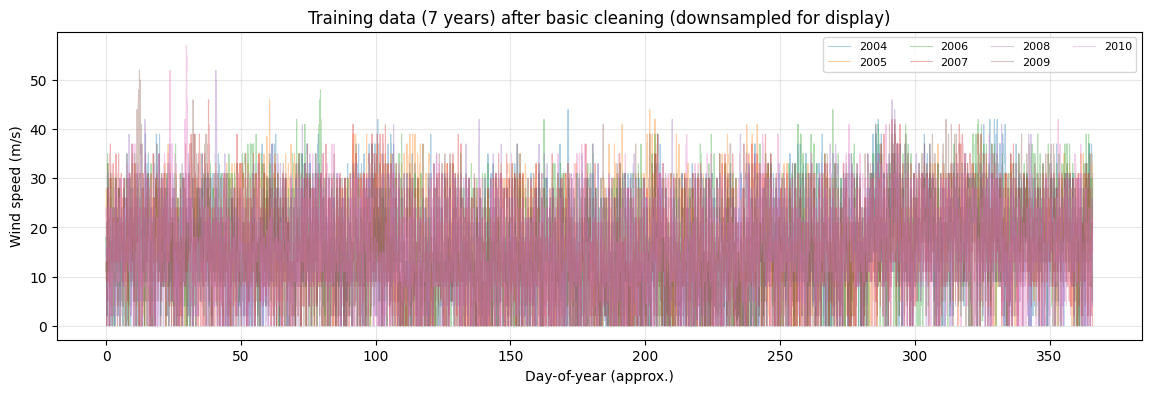

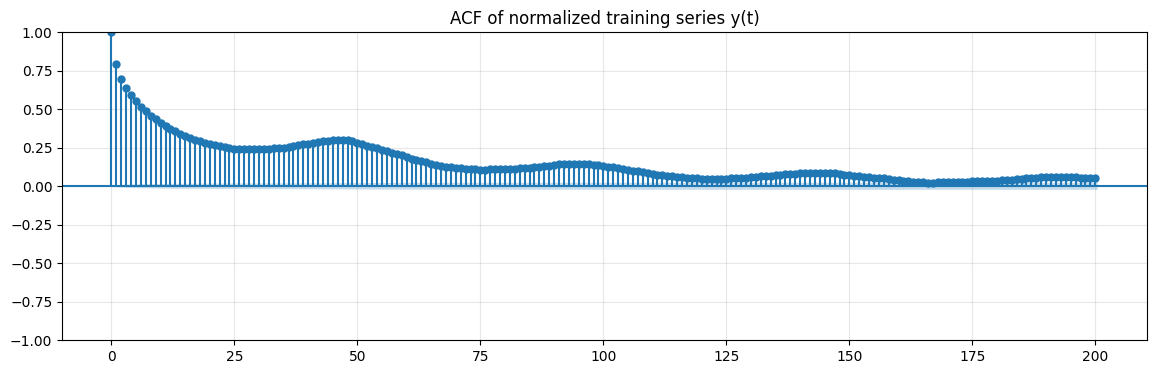

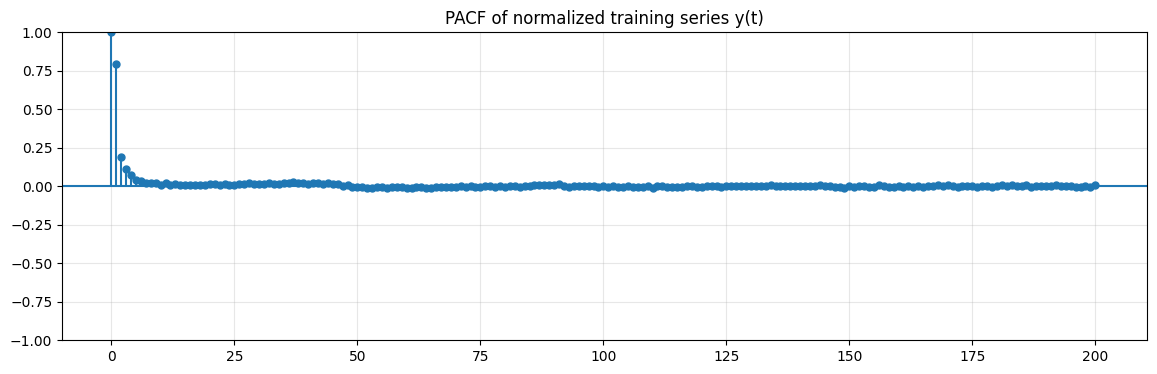

Best ARMA(p,q) by BIC (subset) -> refit on full data
Subset used: 60 days, mode=tail
p* = 2, q* = 1, BIC(subset) = 5347.56

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               122976
Model:                 ARIMA(2, 0, 1)   Log Likelihood             -109962.795
Date:                Wed, 18 Feb 2026   AIC                         219935.590
Time:                        18:24:13   BIC                         219984.189
Sample:                             0   HQIC                        219950.203
                             - 122976                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.014      0.028      0.978      -0.028       0.029
ar.L1  

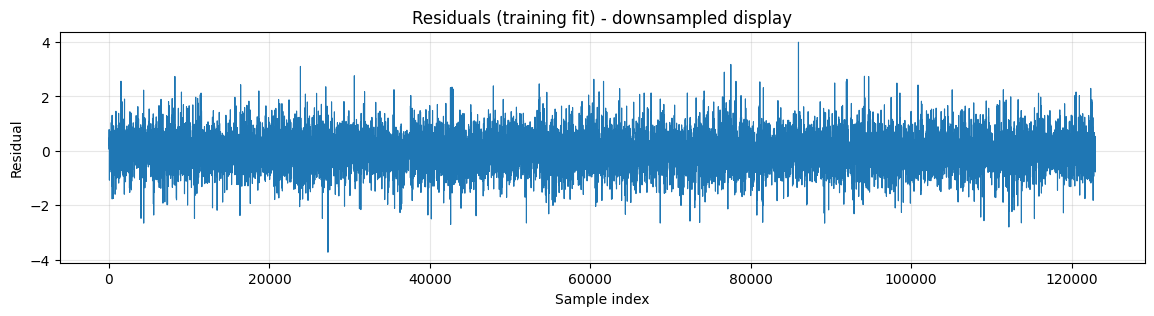

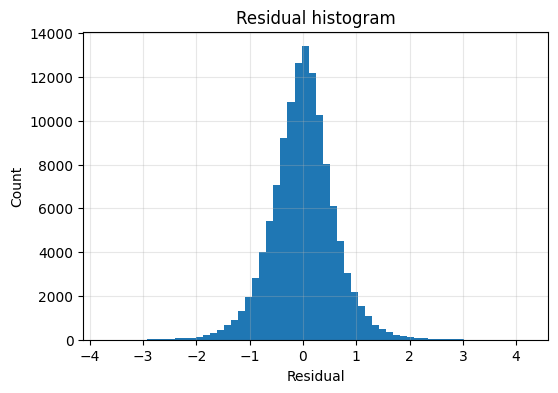

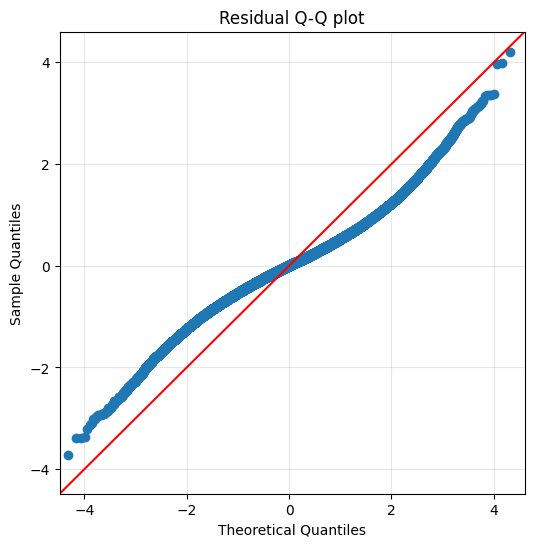

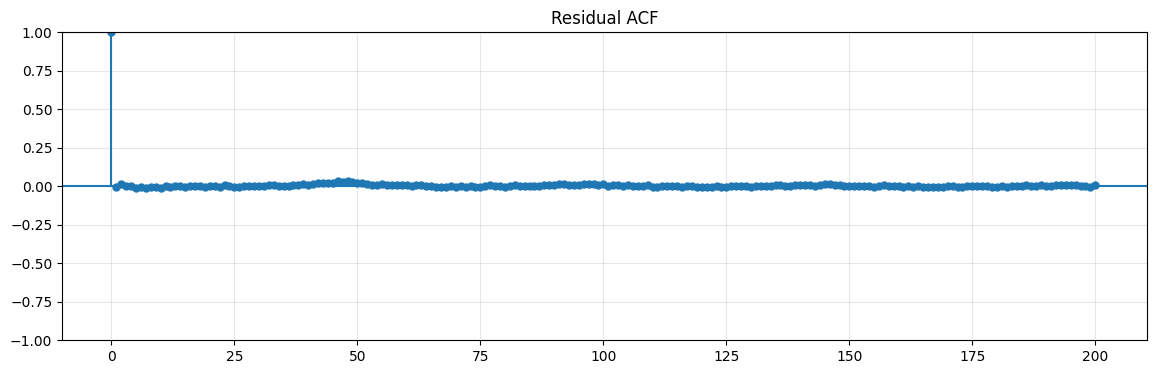

Cell 2 OK: model fitted. p*=2, q*=1


In [6]:
# ---------------------------
# LOAD DATA
# ---------------------------
raw = pd.read_excel(XLS_PATH, sheet_name=SHEET, header=None)
if raw.shape != (17520, 8):
    raise ValueError(f"Expected (17520,8) but got {raw.shape}. Check file/sheet.")

years = list(range(2004, 2012))
data_365 = {}
for i, y in enumerate(years):
    idx = make_365_index(y)
    s = pd.Series(raw.iloc[:, i].values.astype(float), index=idx)
    data_365[y] = s

# Insert Feb29 into every year for consistent 366-slot template
data_366 = {}
for y in years:
    data_366[y] = insert_feb29(data_365[y]).values  # numpy array length 17568

# Split train/test
train_years_366 = {y: data_366[y] for y in TRAIN_YEARS}
test_366 = data_366[TEST_YEAR].astype(float).copy()

# ---------------------------
# CLEAN TRAINING YEARS
# ---------------------------
train_clean, (mu_slot, sig_slot) = clean_outliers_and_zeros(
    train_years_366, VMAX, K_SIGMA, ZERO_RUN_MIN, EPS_WIND
)

# Build normalized training series by concatenating 7 years
years_sorted = sorted(train_clean.keys())
X_train = np.concatenate([train_clean[y] for y in years_sorted])  # length 7*17568

# Repeat mu/sigma across 7 years
mu_rep = np.tile(mu_slot, len(years_sorted))
sig_rep = np.tile(sig_slot, len(years_sorted))

Y_train = (X_train - mu_rep) / (sig_rep + EPS_STD)

# ---------------------------
# PLOT: 7 YEARS OF DATA (raw, cleaned)
# ---------------------------
plt.figure(figsize=(14, 4))
for y in years_sorted:
    x = train_clean[y]
    x_ds, idx_ds = downsample_for_plot(x, MAX_POINTS_PLOT)
    # create a pseudo time axis in days for readability
    t = idx_ds / 48.0
    plt.plot(t, x_ds, alpha=0.35, linewidth=0.8, label=str(y))
plt.xlabel("Day-of-year (approx.)")
plt.ylabel("Wind speed (m/s)")
plt.title("Training data (7 years) after basic cleaning (downsampled for display)")
plt.legend(ncol=4, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------
# ACF / PACF of normalized series
# ---------------------------
plt.figure(figsize=(14, 4))
plot_acf(Y_train, lags=200, ax=plt.gca())
plt.title("ACF of normalized training series y(t)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 4))
plot_pacf(Y_train, lags=200, ax=plt.gca(), method="ywm")
plt.title("PACF of normalized training series y(t)")
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------
# FIT ARMA(p,q) BY BIC (on subset), then refit on full data
# ---------------------------
Y_bic = select_bic_subset(Y_train, days=BIC_SUBSET_DAYS, mode=BIC_SUBSET_MODE)

best = select_arma_bic(Y_bic, P_MAX, Q_MAX)          # fast order selection
p_star, q_star = best["p"], best["q"]

# Refit chosen order on FULL training series (one heavy fit only)
model_full = ARIMA(Y_train, order=(p_star, 0, q_star))
res = model_full.fit()

print("====================================")
print("Best ARMA(p,q) by BIC (subset) -> refit on full data")
print(f"Subset used: {BIC_SUBSET_DAYS} days, mode={BIC_SUBSET_MODE}")
print(f"p* = {p_star}, q* = {q_star}, BIC(subset) = {best['bic']:.2f}")
print("====================================\n")
print(res.summary())


# ---------------------------
# RESIDUAL DIAGNOSTICS
# ---------------------------
resid = res.resid

# Residual time plot (downsampled)
plt.figure(figsize=(14, 3))
r_ds, idx_ds = downsample_for_plot(resid, MAX_POINTS_PLOT)
plt.plot(idx_ds, r_ds, linewidth=0.8)
plt.title("Residuals (training fit) - downsampled display")
plt.xlabel("Sample index")
plt.ylabel("Residual")
plt.grid(True, alpha=0.3)
plt.show()

# Histogram
plt.figure(figsize=(6, 4))
plt.hist(resid, bins=60)
plt.title("Residual histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 6))
sm.qqplot(resid, line="45", ax=plt.gca())
plt.title("Residual Q-Q plot")
plt.grid(True, alpha=0.3)
plt.show()

# Residual ACF
plt.figure(figsize=(14, 4))
plot_acf(resid, lags=200, ax=plt.gca())
plt.title("Residual ACF")
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------
# PREPARE TEST YEAR (clean with same logic, using training climatology)
# ---------------------------
# Outliers in test year: simple cap + global z-rule derived from training X_train
mu_g = np.mean(X_train)
sig_g = np.std(X_train) if np.std(X_train) > 1e-9 else 1.0

x8 = test_366.copy()

# Outlier mask
out = (x8 < 0) | (x8 > VMAX) | (np.abs(x8 - mu_g) > K_SIGMA * sig_g)
x8[out] = np.nan

# Fix zero runs in test year using training climatology mu_slot
runs8 = detect_zero_runs(np.nan_to_num(x8, nan=-9999.0))
for a, b in runs8:
    if (b - a + 1) >= ZERO_RUN_MIN:
        if np.mean(mu_slot[a:b+1]) > EPS_WIND:
            x8[a:b+1] = mu_slot[a:b+1]

# Fill NaNs by training slot mean
nan8 = np.isnan(x8)
x8[nan8] = mu_slot[nan8]

# Normalize test year with training climatology
y8 = (x8 - mu_slot) / (sig_slot + EPS_STD)

MODEL_OK = True
print(f"Cell 2 OK: model fitted. p*={p_star}, q*={q_star}")

**ACF and PACF normalized training series y(t)**

Consider the following:


*   Y-axis is the correlation value
*   X-axis is the lag (0 to 200 half-hours)
*   The lag is a time period of 30 minutes, that is, lag 48 means 1 day of lag.




ACF answers 'how similar is the wind speed now to the wind speed some time ago'.
If the ACF at lag 1 is 0.75, the means that the wind speed now is strongly correlated with wind speed 30 minutes ago. It also means that the wind has persistence. As the lag increases, the correlation decreases, meaning that the memore of the process fades. In short words, the wind does not change abruptly; it evolves gradually.
When ACF decays to 0, the system loses memory as time passes, and this is the type of behavior ARMA models are designed to capture.
If ACF decays slowly, it suggests AR structure. If ACF cuts off quickly, it suggests MA structure.

PACF answers 'after removing intermediate effects, how much direct influence does lag k have?'
PACF is useful to identify AR order. If PACF shows strong spikes at first few lags and drops, then there is a AR(p) behavior. If it gradually decays, it is a mixed ARMA behavior.


**Residual Time Plot**

The residual is the substraction fro, the actual normalized value from the model prediction.
Residuals are OK when: are centered around 0, there is no visible pattern, there is no trend, no periodic structure, and no clustering. Residuals should look like random noise, oscillate randomly, and show no visible structure.

**Residual histogram**

Residual histogram shows what is the distribution of the errors.
ARMA assumes that residuals are approximately white noise, and this noise is often assumed Gaussian (normal). If the histogram is symmetric around zero, and it has bell shape, then the Gaussiam assumption is reasonable. On the contrary, if histogram is skewed, there is an asymmetric wind behavior, possible non linear effects, or maybe there is a heavy gust behavior not captured by ARMA

**Residual Q-Q plot**

This is one of the most important diagnostic tools. T compares samples quantiles (actual residual distribution) and theoretical quantiles (quantiles of a perfect normal distribution).
A quantile is a value below which a certain percentage of data falls. For example, 50% quantile is the median, 95% quantile is the value exceeded only 5% of the time.
What a good Q-Q plot looks like? If residuals are normally distributed, points line approximately on the 45° straight line, and there are small deviations at extreme tails are acceptable. If the tails bend upward, heavy tails means extreme gusts; if tails bend downward, thin tails; is plot shows strong curvature, there is non-normality. Wind data often shows slight heavy tails (due to gust events).

**Residual ACF**

Residual ACF answers the question: is there still memory left in the errors?
If residual ACF shows significant spikes, then the model failed to capture some structure. If the residual ACF is near zero at all lags, then residuals are white noise. In fact, white noise means no remaining predictable structure, and the model captured the linea dependence.


=== 1-Day Forecast Error (Best-BIC ARMA) ===
MAE: 3.4700
RMSE: 5.0180
MAPE_%: 175956105.7082

=== 1-Day Forecast Error (Fixed ARMA(4,1)) ===
MAE: 3.2399
RMSE: 4.5538
MAPE_%: 163274875.0450


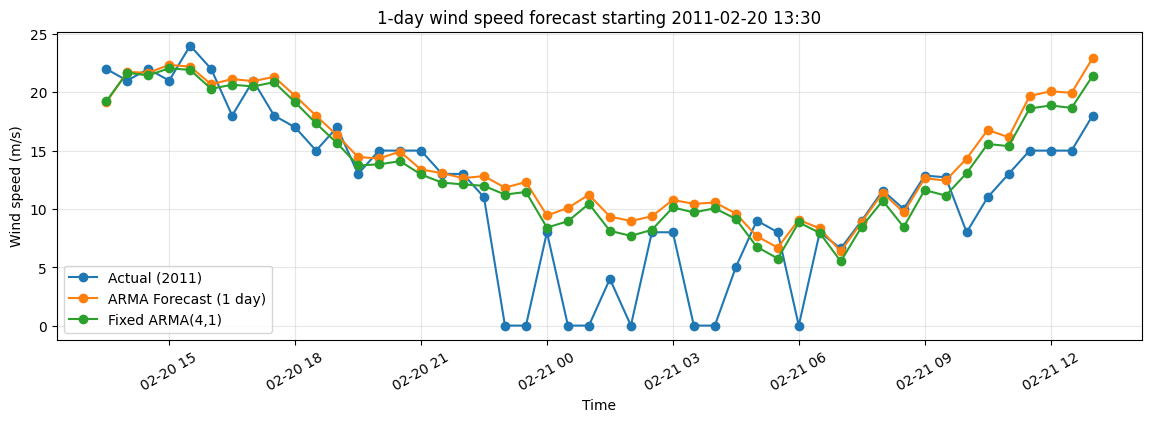


Forecast values (m/s):


,time,actual,forecast
0,2011-02-20 13:30:00,22.000000,19.126605
1,2011-02-20 14:00:00,21.000000,21.744274
2,2011-02-20 14:30:00,22.000000,21.672452
3,2011-02-20 15:00:00,21.000000,22.346743
4,2011-02-20 15:30:00,24.000000,22.195313
5,2011-02-20 16:00:00,22.000000,20.675740
6,2011-02-20 16:30:00,18.000000,21.136825
7,2011-02-20 17:00:00,21.000000,20.951555
8,2011-02-20 17:30:00,18.000000,21.319604
9,2011-02-20 18:00:00,17.000000,19.695908


In [10]:
# ---------------------------
# 1-DAY FORECAST FROM USER TIMESTAMP
# ---------------------------

assert 'MODEL_OK' in globals() and MODEL_OK, "Run Cell 2 first (model not fitted)."

ts = pd.Timestamp(FORECAST_START)

if ts.year != TEST_YEAR:
    raise ValueError(f"FORECAST_START must be in {TEST_YEAR} (got {ts.year}).")

# Convert timestamp to 366-slot index.
# We build a true calendar index for the test year at 30-min resolution INCLUDING Feb29 (if leap),
# then map to 366-slot template by inserting Feb29 into the 365 series (we already did).
#
# So we create a 366-day index for the test year for lookup:
idx_test_366 = pd.date_range(f"{TEST_YEAR}-01-01 00:00", periods=17568, freq="30min")

if ts not in idx_test_366:
    raise ValueError("Timestamp not aligned to 30-min grid or out of range for the year.")

start_i = idx_test_366.get_loc(ts)

# Ensure we have 1 full day ahead available in the year
if start_i + 48 > len(idx_test_366):
    raise ValueError("Forecast start too late in the year; need at least 48 steps ahead.")

# Extend the fitted model state with test-year history up to start_i
# (no refit; we only condition on observed y8 up to that time)
y8_hist = y8[:start_i]
res_ext = res.extend(y8_hist)

fc = res_ext.get_forecast(steps=48)
yhat = fc.predicted_mean  # normalized forecast

# Denormalize forecast back to wind speed using slot mean/std for the forecast horizon
slots = np.arange(start_i, start_i + 48)
xhat = yhat * (sig_slot[slots] + EPS_STD) + mu_slot[slots]

# Actual test data for that horizon
xtrue = x8[slots]

# ---------------------------
# ERROR METRICS (Best-BIC model)
# ---------------------------
metrics_best = forecast_error_metrics(xtrue, xhat)
print("\n=== 1-Day Forecast Error (Best-BIC ARMA) ===")
for k, v in metrics_best.items():
    print(f"{k}: {v:.4f}")

# ---------------------------
# OPTIONAL COMPARISON: Fixed ARMA(4,1)
# ---------------------------
if COMPARE_WITH_FIXED_ARMA_41:
    xhat_41 = forecast_one_day_with_fixed_arma(
        y_train=Y_train,
        y_test=y8,
        start_i=start_i,
        mu_slot=mu_slot,
        sig_slot=sig_slot,
        p=4, q=1,
        steps=48,
        eps_std=EPS_STD
    )

    metrics_41 = forecast_error_metrics(xtrue, xhat_41)
    print("\n=== 1-Day Forecast Error (Fixed ARMA(4,1)) ===")
    for k, v in metrics_41.items():
        print(f"{k}: {v:.4f}")


# Plot forecast
t_axis = idx_test_366[slots]

plt.figure(figsize=(14, 4))
plt.plot(t_axis, xtrue, marker="o", linewidth=1.5, label="Actual (2011)")
plt.plot(t_axis, xhat, marker="o", linewidth=1.5, label="ARMA Forecast (1 day)")
if COMPARE_WITH_FIXED_ARMA_41:
    plt.plot(t_axis, xhat_41, marker="o", linewidth=1.5, label="Fixed ARMA(4,1)")

plt.title(f"1-day wind speed forecast starting {FORECAST_START}")
plt.xlabel("Time")
plt.ylabel("Wind speed (m/s)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=30)
plt.show()

print("\nForecast values (m/s):")
display(pd.DataFrame({"time": t_axis, "actual": xtrue, "forecast": xhat}))
